In [0]:
%%capture
%cd /content
!git clone --depth 1 https://github.com/RodrigoAgronomia/smart_tmp.git
%cd /content/smart_tmp
!git pull
%cd /content/smart_tmp/python

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
import cv2
import time
import json
import pickle
import natsort
import numpy as np
import torch
import shutil
from torch.autograd import Variable
from matplotlib import pyplot as plt
from cnn import SegmentationModel as net

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [0]:
def bb_iou(boxes1, boxes2):
    x11, y11, x12, y12 = np.split(boxes1, 4, axis=1)
    x21, y21, x22, y22 = np.split(boxes2, 4, axis=1)
    xA = np.maximum(x11, np.transpose(x21))
    yA = np.maximum(y11, np.transpose(y21))
    xB = np.minimum(x12, np.transpose(x22))
    yB = np.minimum(y12, np.transpose(y22))
    interArea = np.maximum((xB - xA + 1), 0) * np.maximum((yB - yA + 1), 0)
    boxAArea = (x12 - x11 + 1) * (y12 - y11 + 1)
    boxBArea = (x22 - x21 + 1) * (y22 - y21 + 1)
    iou = interArea / (boxAArea + np.transpose(boxBArea) - interArea)
    return iou

In [0]:
def colorir(cat):
    h, w = cat.shape[:2]
    msk = np.zeros((h,w,3), dtype = 'uint8')
    msk[cat == 1] = [0,255,0]
    msk[cat == 2] = [0,0,255]
    return(msk)

In [0]:
def get_bboxes(contours, minArea, maxArea, minDst, maxDst):
    bboxes = []
    for cnt in contours:
        area = cv2.contourArea(cnt)
        bbox = cv2.boundingRect(cnt)
        x,y,w,h = np.array(bbox)
        if area >  minArea and area < maxArea:
            if (x > minDst) and ((x+w) < maxDst):
                bboxes.append([x,y,x+w,y+h])
    return(np.array(bboxes))

In [0]:
def transform(x):
    x = x.copy()
    x = x.astype('float')
    x -= 128
    x /= 35
    x = np.moveaxis(x, 2, 0)
    x = x[np.newaxis]
    x = torch.from_numpy(x)
    x = Variable(x).to(device, dtype=torch.float)
    return(x)

In [0]:
def get_cat(frame):
    img = transform(frame)
    pred, feat = model(img)
    pred = pred.cpu().data.numpy()
    pred = np.moveaxis(pred, 1, 3)
    pred = np.squeeze(pred)
    cat = np.argmax(pred, 2).astype('uint8')
    return(cat)

In [27]:
n_classes = 3

# Atribui o modelo
model = net.EESPNet_Seg(n_classes, s=0.5, pretrained='', gpus=1)
model = model.to(device)
model.load_state_dict(torch.load('../data/Tracking.pth',map_location=device))


# set to evaluation mode
model.eval()

print('Modelo Ok')

Modelo Ok


In [0]:
# fotos_dir = '/content/drive/My Drive/SmartAgri/Smart Selection/Fotos/26_07_2019'
# shutil.copytree(fotos_dir, '../data/Fotos/')
fotos_dir = '../data/Fotos/'

In [0]:
frames_dir = '../data/Plantass/'
os.makedirs(frames_dir)

In [0]:
input_height = 2464
input_width = 3264

output_height = 384
output_width = 512

ioh, iow = input_height/output_height, input_width/output_width
iocv = np.array([iow, ioh, iow, ioh])

frame_files = natsort.natsorted(os.listdir(fotos_dir))


font = cv2.FONT_HERSHEY_SIMPLEX  
ini_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 5))
fourcc = cv2.VideoWriter_fourcc(*'XVID')
  

In [56]:
print(len(frame_files))
iocv

1462


array([6.375     , 6.41666667, 6.375     , 6.41666667])

In [57]:
save_file = '../data/Plantas.avi'
json_file = '../data/Plantas.json'

out = cv2.VideoWriter(save_file, fourcc, 30.0, (output_width, output_height))
print(save_file)

old_plant_boxes = new_plant_boxes = tmp_plant_boxes = np.array([]) # inicialize the boxes vector
old_stem_boxes = new_stem_boxes = tmp_stem_boxes = np.array([])
video_history = {}

n_plantas = 1 # counter
n_frames = 1
speed = 25 
last_speed = speed
speed_avg = speed * np.ones(10)


n_frames = len(frame_files)
t_start = time.time()                 
for i in range(n_frames):
    print(i)
    start_time = time.time()
    frameo = cv2.imread(os.path.join(fotos_dir, frame_files[i]))
    frame = cv2.resize(frameo, (output_width, output_height))
    cat = get_cat(frame)

    # apply the overlay
    alpha = 0.5
    pred = colorir(cat)
    framec = cv2.resize(pred, (output_width, output_height))
    cv2.addWeighted(framec, alpha, frame, 1 - alpha, 0, frame)


    # Cria duas mascaras, a primeira para planta + tubete e a segunda apenas do tubete:
    plant_msk = (cat > 0).astype('uint8')
    stem_msk = (cat == 2).astype('uint8')

    # Aplica um kernel vertical, para evitar que existam interrupcoes no contorno das plantas,
    # o que causaria a existencia de dois bbox:
    plant_msk = cv2.dilate(plant_msk, ini_kernel, iterations = 15)
    stem_msk = cv2.dilate(stem_msk, ini_kernel, iterations = 5)

    # Encontra os bbox das plantas com tubetes, que depois eh enconlhido para ficar soh a planta:
    im_tmp, contours, hierarchy = cv2.findContours(plant_msk, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    new_plant_boxes = get_bboxes(contours, 5000, 500000, 10, 500)

    # Encontra os bbox dos tubetes, que depois sao movidos para a posicao do caule:
    im_tmp, contours, hierarchy = cv2.findContours(stem_msk, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    new_stem_boxes = get_bboxes(contours, 100, 10000, 10, 500) 

    if new_plant_boxes.size > 0:
        # Ordena os bbox pelo eixo x, para que o primeiro fique a direita e o ultimo a esquerda:
        new_plant_boxes = new_plant_boxes[new_plant_boxes[:,0].argsort()[::-1]]

        # Define um criterio para os bbox que estao apenas na primeira metade do video:
        mcrit = np.ones(len(new_plant_boxes), dtype=bool)
        mcrit[new_plant_boxes[:,0] < 10] = False
        mcrit[new_plant_boxes[:,2] > frame.shape[1]/2] = False

        # Se ja existem bbox anteriores, atualiza com os correspondentes:
        if old_plant_boxes.size > 0 :
            areas = bb_iou(new_plant_boxes, old_plant_boxes)
            ncrit = np.where(areas.max(0) > 0)
            acrit = areas.argmax(0)[ncrit]
            old_plant_boxes[ncrit] = new_plant_boxes[acrit]
            mcrit[acrit] = False

        # Armazena os bbox nao correspondentes, eles seram avaliados ao final e incluidos se forem validos:
        tmp_plant_boxes = new_plant_boxes[mcrit]


    if new_stem_boxes.size > 0:
        # Ordena os bbox pelo eixo x, para que o primeiro fique a direita e o ultimo a esquerda:
        new_stem_boxes = new_stem_boxes[new_stem_boxes[:,0].argsort()[::-1]]       

        # Define um criterio para os bbox que estao apenas na primeira metade do video:
        mcrit = np.ones(len(new_stem_boxes), dtype=bool)
        mcrit[new_stem_boxes[:,0] < 10] = False
        mcrit[new_stem_boxes[:,2] > frame.shape[1]/2] = False

        # Se ja existem bbox anteriores, atualiza com os correspondentes:
        if old_stem_boxes.size > 0 :
            areas = bb_iou(new_stem_boxes, old_stem_boxes)
            ncrit = np.where(areas.max(0) > 0)
            acrit = areas.argmax(0)[ncrit]        

            # Utiliza os bbox correspondentes para calcular a velocidade (px/frame):
            # Obs: O calculo ocorre aqui porque eh mais estavel calcular com base nos tubetes
            last_speed += np.mean(new_stem_boxes[acrit,0] - old_stem_boxes[ncrit,0])
            if last_speed > 0:
                speed_avg = np.insert(speed_avg, 0, last_speed)[:10]
                print("Speed:" + str(speed))
            else:
                last_speed = speed
            speed = int(np.mean(speed_avg))
            old_stem_boxes[ncrit] = new_stem_boxes[acrit]
            mcrit[acrit] = False
        # Armazena os bbox nao correspondentes, eles seram avaliados ao final e incluidos se forem validos:
        tmp_stem_boxes = new_stem_boxes[mcrit]


    # Se for a primeira planta a ser identificada, atribui o bbox para plotar:
    if old_plant_boxes.size == 0 and old_stem_boxes.size == 0 :
        if tmp_plant_boxes.size > 0 and tmp_stem_boxes.size > 0 :
            old_stem_boxes = tmp_stem_boxes
            old_plant_boxes = tmp_plant_boxes
            tmp_stem_boxes = tmp_plant_boxes = np.array([])


    # Inicia o dicionario que vai salvar as coordendas dos dois bbox para cada planta:
    frame_str = {}
    if old_plant_boxes.size > 0 and old_stem_boxes.size > 0 :
        # Garante que os bbox da planta e do caule sao da mesma planta (intersectam):
        areas = bb_iou(old_plant_boxes, old_stem_boxes)
        nidx = areas.argmax(1)

        for idx, ix in enumerate(nidx):
            sbb = old_stem_boxes[ix].copy()
            if areas.max(1)[idx] > 0 and (sbb[0] > 10) and (frame.shape[1] - sbb[2]) > 10:

                # Para cada bbox da planta realiza os ajustes na posicao, plota no frame e adiciona no dicionario:
                bb = old_plant_boxes[idx].copy()
                bb[3] = sbb[1] + 10
                plant_bb = np.int0(bb*iocv).tolist()
                frame = cv2.rectangle(frame,(bb[0], bb[1]), (bb[2], bb[3]),(0,0,255), 2)
                cv2.putText(frame, 'P{}'.format(idx + n_plantas),(int(np.mean(bb[[0,2]])), bb[1]), font, 1,(255,255,255),2,cv2.LINE_AA)

                # Para cada bbox do caule realiza os ajustes na posicao, plota no frame e adiciona no dicionario:
                xm = int(np.mean(sbb[[0,2]]))
                sbb[[0,2]] = xm + np.array([-20,20])
                sbb[[1,3]] = [sbb[1] - 10, sbb[1] + 10]                    
                stem_bb = np.int0(sbb*iocv).tolist()
                frame = cv2.rectangle(frame,(sbb[0], sbb[1]),(sbb[2], sbb[3]),(255,0,0), 2)
                cv2.putText(frame, 'P{}'.format(idx + n_plantas),(xm, sbb[3]), font, 1,(255,255,255),2,cv2.LINE_AA)

                frame_str['P{}'.format(idx + n_plantas)] = {'Plant':plant_bb, 'Stem':stem_bb}


    # Adiciona ao dicionario do video as informacoes desse frame:
    video_history['Frame{:04d}'.format(i)] = frame_str
    frame_bbox = frame_str
    for p in frame_bbox.keys():
        f_bbox = frame_bbox.get(p)
        pbox = np.array(f_bbox.get('Plant'))
        pbox = np.int0(pbox)#*iocv)
        pbox[1] += 80               
        pbox[3] += 40               
        plantf_name = '_{}_F{:04d}.jpg'.format(p, i)
        plant_file = frames_dir + plantf_name
        cv2.imwrite(plant_file,frameo[pbox[1]:pbox[3], pbox[0]:pbox[2]])
    print(frame_str)

    # Nessa parte vou adicionar o outro modelo, que vai fazer a classificacao:
    # classificar(frame, planta)

    # Se existem novos bbox, adiciona ao conjunto que sera avaliado no proximo frame:
    if tmp_plant_boxes.size > 0 and tmp_stem_boxes.size > 0 and tmp_plant_boxes.size == tmp_stem_boxes.size:
        old_stem_boxes = np.concatenate([tmp_stem_boxes, old_stem_boxes])
        old_plant_boxes = np.concatenate([tmp_plant_boxes, old_plant_boxes])

    # Realiza a predicao da posicao de cada bbox no proximo frame, com base na velocidade instantanea:
    if old_plant_boxes.size > 0 and old_stem_boxes.size > 0 :
        old_stem_boxes += np.int0(last_speed * np.array([[1,0,1,0]]))
        old_stem_boxes = old_stem_boxes[old_stem_boxes[:,0].argsort()[::-1]]

        old_plant_boxes += np.int0(last_speed * np.array([[1,0,1,0]]))
        old_plant_boxes = old_plant_boxes[old_plant_boxes[:,0].argsort()[::-1]]

        # Remove os bbox que estarao fora da imagem, e conta como uma nova planta:
        # Obs: Esse sera o momento de enviar o controle com a classificacao da planta
        fcrit = old_stem_boxes[:,3] < frame.shape[1]
        if not fcrit.all():
            old_plant_boxes = old_plant_boxes[fcrit]
            old_stem_boxes = old_stem_boxes[fcrit]
            n_plantas += 1         


    # Estou salvando apenas os frames com planta e movimento detectados:
    if last_speed > 10 and len(frame_str) > 0:
        out.write(frame) 
    t_now = time.time()


    fps = i /(t_now - t_start)
    if i % 10 == 0:
        print('Running at {} FPS'.format(fps))

out.release()

# Salva o dicionario em json com as informacoes desse video:
with open(json_file, 'w') as outfile:
    json.dump(video_history, outfile)

time_taken = time.time() - start_time
print('PreProc time: %.2f' % time_taken)  



../data/Plantas.avi
0
{}
Running at 0.0 FPS
1
{}
2
{}
3
{}
4
{}
5
{}
6
{}
7
{}
8
{}
9
{}
10
{}
Running at 9.759404147097113 FPS
11
{}
12
{}
13
{}
14
{}
15
{}
16
{}
17
{}
18
{}
19
{}
20
{}
Running at 9.85184893752081 FPS
21
{}
22
{}
23
{}
24
{}
25
{}
26
{}
27
{}
28
{}
29
{}
30
{}
Running at 9.676276569189591 FPS
31
{}
32
{}
33
{}
34
{}
35
{}
36
{}
37
{}
38
{}
39
{}
40
{}
Running at 9.675928897689024 FPS
41
{}
42
{}
43
{}
44
{}
45
{}
46
{}
47
{}
48
{}
49
{}
50
{}
Running at 9.672028096196728 FPS
51
{}
52
{}
53
{}
54
{}
55
{}
56
{}
57
{}
58
{}
59
{}
60
{}
Running at 9.62678927041961 FPS
61
{}
62
{}
63
{}
64
{}
65
{}
66
{}
67
{}
68
{}
69
{}
70
{}
Running at 9.638756034660632 FPS
71
{}
72
{}
73
{}
74
{}
75
{}
76
{}
77
{}
78
{}
79
{}
80
{}
Running at 9.640834271670121 FPS
81
{}
82
{}
83
{}
84
{}
85
{}
86
{}
87
{}
88
{}
89
{}
90
{}
Running at 9.644649574770407 FPS
91
{}
92
{}
93
{}
94
{}
95
{}
96
{}
97
{}
98
{}
99
{}
100
{}
Running at 9.656263767351467 FPS
101
{}
102
{}
103
{}
104
{}
105
{}
1

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Speed:17
{'P7': {'Plant': [433, 1398, 988, 1982], 'Stem': [726, 1854, 981, 1982]}}
333
Speed:17
{'P7': {'Plant': [777, 1398, 1313, 1982], 'Stem': [847, 1854, 1102, 1982]}}
334
Speed:17
{'P7': {'Plant': [962, 1353, 1593, 1989], 'Stem': [969, 1860, 1224, 1989]}}
335
Speed:17
{'P7': {'Plant': [1058, 1341, 1734, 1989], 'Stem': [1058, 1860, 1313, 1989]}}
336
Speed:17
{'P7': {'Plant': [1173, 1289, 1861, 1989], 'Stem': [1179, 1860, 1434, 1989]}}
337
Speed:17
{'P7': {'Plant': [1268, 1283, 1912, 1982], 'Stem': [1275, 1854, 1530, 1982]}}
338
Speed:17
{'P7': {'Plant': [1383, 1264, 1855, 1982], 'Stem': [1389, 1854, 1644, 1982]}}
339
Speed:17
{'P7': {'Plant': [1434, 1264, 1823, 1982], 'Stem': [1510, 1854, 1765, 1982]}}
340
Speed:17
{'P7': {'Plant': [1377, 1270, 1867, 1989], 'Stem': [1606, 1860, 1861, 1989]}}
Running at 9.299822072179586 FPS
341
Speed:16
{'P7': {'Plant': [1351, 1283, 1982, 1982], 'Stem': [1721, 1854, 1976, 1982]}}
342
Speed:17
{'P7': {'Plant': [1364, 1296, 2078, 1989], 'Stem': [1816

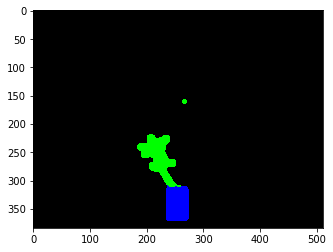

In [58]:
plt.imshow(pred)

In [59]:
shutil.make_archive('../data/Plantass', 'zip', '../data/Plantass/')

'/content/smart_tmp/data/Plantass.zip'